In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [2]:
# read the data

train_data = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv', index_col = "id")
test_data = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv', index_col = "id")
sample_sub = pd.read_csv('/kaggle/input/playground-series-s5e8/sample_submission.csv')
print(train_data.shape)
print(test_data.shape)


(750000, 17)
(250000, 16)


In [3]:
train_data.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
5,24,admin.,single,secondary,no,1882,yes,no,cellular,20,apr,1010,3,-1,0,unknown,0
6,39,blue-collar,married,secondary,no,0,no,no,telephone,21,nov,90,1,-1,0,unknown,0
7,50,admin.,single,secondary,no,1595,no,no,telephone,31,jul,49,25,-1,0,unknown,0
8,46,blue-collar,married,primary,no,1463,no,no,cellular,4,aug,50,1,-1,0,unknown,0


In [4]:
train_data.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [5]:
# data visualization
# numerical 7 cols (not including id)

# id & target value 2 cols
correlation = train_data.corr(numeric_only = True)
correlation['y'].sort_values(ascending = False)


y           1.000000
duration    0.519283
balance     0.122513
previous    0.119552
pdays       0.089277
age         0.009523
day        -0.049625
campaign   -0.075829
Name: y, dtype: float64

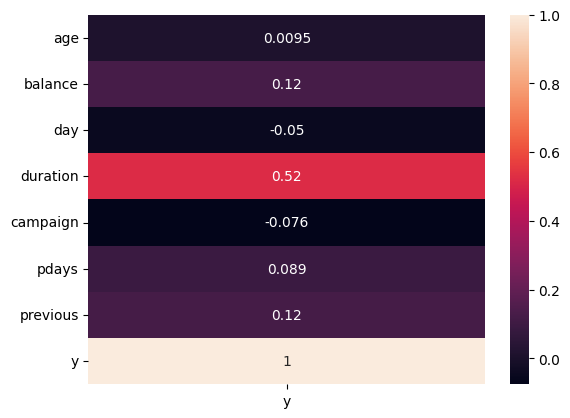

In [6]:
sns.heatmap(correlation[['y']], annot = True, color = 'blue')
plt.show()

In [7]:
# categorical 9 cols
columns = ['job', 'marital','education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

print(train_data.groupby('job')['y'].mean().sort_values(ascending = False))
train_data['education'].value_counts().sort_values(ascending=False)

# plt.figure(figsize = (20, 10))
# sns.countplot(x = 'job', data = train_data)
# plt.show()

job
student          0.340784
retired          0.246241
unemployed       0.179823
management       0.150392
self-employed    0.129443
unknown          0.120672
technician       0.118321
admin.           0.116453
housemaid        0.084653
services         0.082714
entrepreneur     0.081386
blue-collar      0.067438
Name: y, dtype: float64


education
secondary    401683
tertiary     227508
primary       99510
unknown       21299
Name: count, dtype: int64

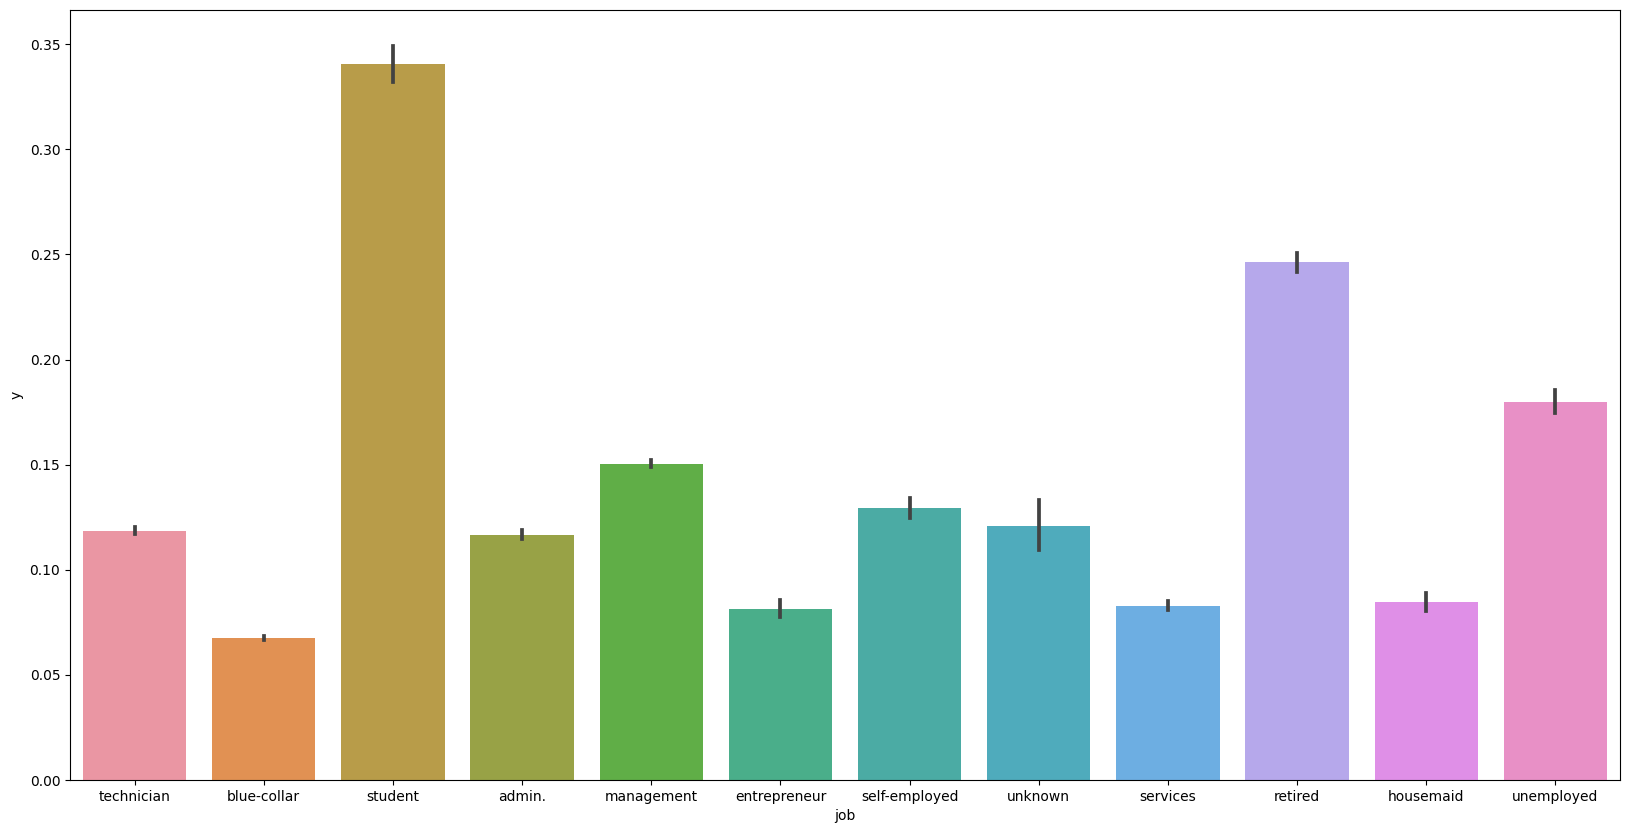

In [8]:
plt.figure(figsize = (20, 10))
sns.barplot(x = train_data['job'], y = train_data['y'])
plt.show()
# student 0.340784 retired 0.246241
# mar    0.571355 sep    0.534755 dec    0.513291 oct    0.490004 apr    0.235654 feb    0.206801
# poutcome success 0.764004

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


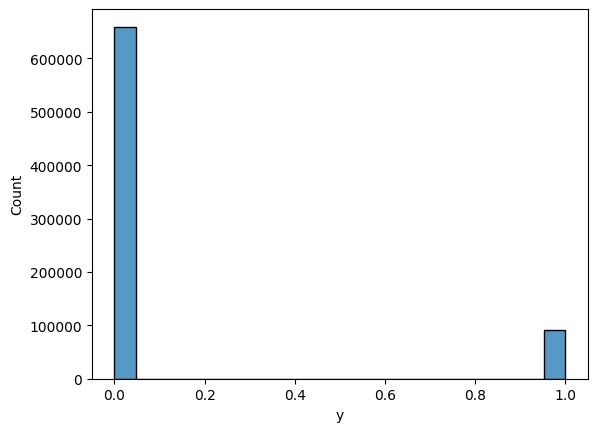

In [9]:
# target data visualization
target = sns.histplot(train_data['y'])

# imbalanced data

In [10]:
# missing value
miss_value = train_data.isnull().sum()
print(miss_value)
miss2_value = test_data.isnull().sum()
print(miss2_value)

# dont have to deal with the missing value

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64


In [11]:
# data preprocessing
# One-Hot Encoding
columns = ['job', 'marital','education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

train_data['source'] = 'train'
test_data['source'] = 'test'

data = pd.concat([train_data, test_data], axis = 0)
data = pd.get_dummies(data, columns = columns, drop_first = False)

train_data = data[data['source']=='train'].drop('source', axis = 1)
test_data = data[data['source']=='test'].drop('source', axis = 1)

print('Encoding finished')

Encoding finished


In [12]:
# data preprocessing
# Label Encoding
# one_hot_columns = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']
# label_columns = ['education', 'month']

# for col in label_columns:
#     encoder = LabelEncoder()
#     train_data[col] = encoder.fit_transform(train_data[col])
#     test_data[col] = encoder.transform(test_data[col])
# train_data = pd.get_dummies(train_data)
# test_data = pd.get_dummies(test_data)
# print('Encoding finished')

In [13]:
print(train_data)
print(test_data)

        age  balance  day  duration  campaign  pdays  previous    y  \
id                                                                    
0        42        7   25       117         3     -1         0  0.0   
1        38      514   18       185         1     -1         0  0.0   
2        36      602   14       111         2     -1         0  0.0   
3        27       34   28        10         2     -1         0  0.0   
4        26      889    3       902         1     -1         0  1.0   
...     ...      ...  ...       ...       ...    ...       ...  ...   
749995   29     1282    4      1006         2     -1         0  1.0   
749996   69      631   19        87         1     -1         0  0.0   
749997   50      217   17       113         1     -1         0  0.0   
749998   32     -274   26       108         6     -1         0  0.0   
749999   42     1559    4       143         1      1         7  0.0   

        job_admin.  job_blue-collar  ...  month_jun  month_mar  month_may  \

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [14]:
diff_cols = set(train_data.columns).symmetric_difference(test_data.columns)
print("Different columns:", diff_cols)

Different columns: set()


In [15]:
# Model training and hyperparameter tuning 

# current best score is around 0.9582

# max_d = 20
# min_split = 8
# estimators = 150

# columns_to_drop = ['y', 'day', 'campaign', 'age', 'id']

# X = train_data.drop(['y'], axis = 1)
# y = train_data['y']

# model = RandomForestClassifier(max_depth = 20, min_samples_split = 8, n_estimators = 150, class_weight = 'balanced', random_state = 42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
# score = cross_val_score(model, X, y, cv = cv, scoring = 'roc_auc')

# param_grid = {
#     'n_estimators': [100, 150],
#     'max_depth': [15, 20],
#     'min_samples_split': [2, 5, 8]
# }
# print('-----------Training start-----------')

# grid_search = GridSearchCV(model, param_grid, cv = 3, scoring = 'roc_auc', n_jobs = -1, verbose = 2)

# grid_search.fit(X_train, y_train)

# print('best parameter', grid_search.best_params_)
# print('best score', grid_search.best_score_)

# best_model = grid_search.best_estimator_
# pred = best_model.predict_proba(X_test)[:, 1]

# score = roc_auc_score(y_test, pred)
# # 20 2 100
# print('ROC_AUC score: ', score)

print('-----------Training  finished-----------')

-----------Training  finished-----------


In [16]:
# Testing (by using XGBoost)

X = train_data.drop(['y'], axis = 1)
y = train_data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = XGBClassifier(
    n_estimators=200,      
    max_depth=5,           
    learning_rate=0.1,     
    scale_pos_weight=1,   
    random_state=42,
    use_label_encoder=False
)

# 訓練模型
model.fit(X_train, y_train)

# 預測機率
y_pred_prob = model.predict_proba(X_test)[:, 1]

# 評估 ROC AUC
auc = roc_auc_score(y_test, y_pred_prob)

print("ROC AUC:", auc)

ROC AUC: 0.9640929502769949


In [17]:
# Final model training

X_train = train_data.drop(['y'], axis = 1)
y_train = train_data['y']
X_test = test_data.drop(['y'], axis = 1)

model = XGBClassifier(
    n_estimators=200,      
    max_depth=5,           
    learning_rate=0.1,     
    scale_pos_weight=1,   
    random_state=42,
    use_label_encoder=False
)

model.fit(X_train, y_train)

pred = model.predict_proba(X_test)[:, 1]

print('Prediction finished')



Prediction finished


In [18]:
# submission
print(pred)
submission = pd.DataFrame({
    'id': sample_sub['id'],
    'y': pred
})

submission.to_csv('submission.csv', index = False)

print('submission finished')

submission.head(5)

[3.2620681e-03 1.3163041e-01 3.6030915e-04 ... 8.2678062e-01 1.0614101e-03
 1.0890219e-01]
submission finished


,id,y
0,750000,0.003262
1,750001,0.131630
2,750002,0.000360
3,750003,0.000168
4,750004,0.033521
